### Generate Predictions using Trained Models

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))

import xarray as xr
import matplotlib.pyplot as plt
import gcsfs
import json
#fs = gcsfs.GCSFileSystem()

In [2]:
import diffusers
import diffusionsim as diff

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Loading Data

In [4]:
fs = gcsfs.GCSFileSystem()
fs.ls("gs://leap-scratch/sammyagrawal/")

['leap-scratch/sammyagrawal/input_climsim_small.npy',
 'leap-scratch/sammyagrawal/output_climsim_small.npy']

In [5]:
X, Y = diff.load_numpy_arrays(bucket='scratch', fprefix='climsim_small')

Finished Loading X from gs://leap-scratch/sammyagrawal/input_climsim_small.npy
Finished Loading Y from gs://leap-scratch/sammyagrawal/output_climsim_small.npy


In [6]:
Xarr, Yarr = diff.reconstruct_xarr_from_npy(
    X, Y, 
    #subsampling=(0, 210240, 144),
    subsampling=(210240-288,210240, 144), 
    data_vars='v1', 
)

In [7]:
Xarr.shape, Yarr.shape

((768, 124), (768, 128))

In [8]:
mli, mlo = Xarr.mli, Yarr.mlo
a, b = diff.mydatasets.add_space(Xarr.unstack('state'), Yarr.unstack('state'))

### Loading Models and Inference Pipelines

In [3]:
def load_config(fname, expid, base_dir="experiments/"):
    if 'json' not in fname:
        fname += ".json"
    with open(os.path.join(base_dir, expid, fname), 'r') as f:
        cdict = json.load(f)
    try:
        tconfig = diff.TrainingConfig(**cdict['training_config'])
    except:
        print("mismatch between tconfig and class")
        tconfig = cdict['training_config']
    try:
        mconfig = diff.ModelConfig(**cdict['model_config'])
    except:
        print("mismatch between mconfig and class")
        mconfig = cdict['model_config']
    
    return(tconfig, mconfig)
    
tconfig, mconfig = load_config("trial_log", "test_ddpm_1")

In [4]:
mconfig.unet.sample_size

[16, 24]

In [11]:
test_ds = diff.ClimsimImageDataset(Xarr, Yarr, mconfig=mconfig, device=device, channel_first=False)

Normalizing data


NameError: name 'asdict' is not defined

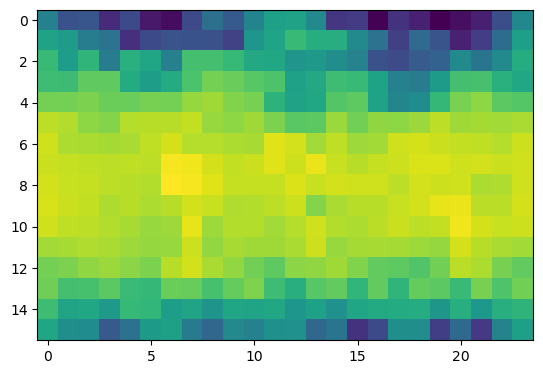

In [13]:
plt.imshow(test_ds[0][:, :, 59].detach().cpu())

In [262]:

def load_model(config):
    registered = ['VAE', 'diffusion', 'latent_diffusion']
    match config.model_type.lower():
        case "vae":
            model = diff.models.VariationalAutoencoder(
                data_dims= config.num_channels, 
                latent_dims= config.latent_dims, 
                hidden_dims= config.ae_hidden_dims, 
            )
            if ( hasattr(config, "disable_enc_logstd_bias") ):
                layer = torch.nn.Linear(config.ae_hidden_dims[-1], config.latent_dims, bias=not config.disable_enc_logstd_bias )
                model.encoder.enc_logstd = layer
            return(model)
        case model_type if "diffusion" in model_type:
            channels = config.latent_dims if 'latent' in model_type else config.in_channels
            model = diffusers.UNet2DModel(
                sample_size=(config.image_height, config.image_width),  # the target image resolution
                in_channels=channels,  # the number of input channels, 3 for RGB images
                out_channels=channels,  # the number of output channels
                layers_per_block=1,  # how many ResNet layers to use per UNet block
                block_out_channels=config.block_out_channels, 
                down_block_types=config.down_blocks, 
                up_block_types=config.up_blocks,
                norm_num_groups=16, 
            )
            return(model)
    return(-1)

In [15]:
mconfig.scheduler

SchedulerParams(num_train_timesteps=100, beta_schedule='linear', clip_sample=True, clip_sample_range=1.0)

In [217]:
def load_scheduler(config):
    def pass_config(func, data_class):
        accepted_params = inspect.signature(func).parameters
        filtered_kwargs = {k: v for k, v in asdict(data_class).items() if k in accepted_params}
        return func(**filtered_kwargs)
    match config.scheduler_type.lower():
        case sched if 'ddpm' in sched:
            # in charge of betas
            return(pass_config(diffusers.DDPMScheduler, config.scheduler))
        case sched if 'ddim' in sched:
            return(pass_config(diffusers.DDIMScheduler, config.scheduler))
        case other if True:
            print(f"scheduler '{other}' not yet supported")

In [218]:
load_scheduler(mconfig)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.30.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": false,
  "clip_sample_range": 4.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 100,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [188]:
asdict(ModelConfig().scheduler)

{'scheduler_type': 'ddpm',
 'num_timesteps': 100,
 'beta_schedule': 'linear',
 'clip_sample': False,
 'clip_sample_range': 4.0}

In [7]:
def fetch_model_from_ckpt(ckpt_fname, log_fname, expid, base_dir="experiments/"):
    tconfig, mconfig = load_config(log_fname, expid, base_dir)
    model = diff.load_model(mconfig)
    cpath = os.path.join(base_dir, expid, ckpt_fname)
    model.load_state_dict(torch.load(cpath, map_location=torch.device(device)))
    return(model)

In [8]:
ddpm = fetch_model_from_ckpt("best-ckpt.pt", "trial_log", "test_ddpm_1")

In [17]:
vae = fetch_model_from_ckpt("best-ckpt.pt", "trial_log.json", "VAE_August05_08:23")

mismatch between tconfig and class


In [20]:
os.listdir('experiments/test_ddpm_1')

['best-ckpt.pt', 'e24-ckpt.pt', '.ipynb_checkpoints', 'trial_alpha_log.json']

In [179]:
diffusers.DDIMScheduler(num_train_timesteps=mconfig.num_timesteps, clip_sample=False) 

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.30.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 100,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [169]:
scheduler = diff.mydatasets.load_scheduler(mconfig)
scheduler.config.clip_sample = False
scheduler, scheduler.config.clip_sample

(DDIMScheduler {
   "_class_name": "DDIMScheduler",
   "_diffusers_version": "0.30.0",
   "beta_end": 0.02,
   "beta_schedule": "linear",
   "beta_start": 0.0001,
   "clip_sample": true,
   "clip_sample_range": 1.0,
   "dynamic_thresholding_ratio": 0.995,
   "num_train_timesteps": 100,
   "prediction_type": "epsilon",
   "rescale_betas_zero_snr": false,
   "sample_max_value": 1.0,
   "set_alpha_to_one": true,
   "steps_offset": 0,
   "thresholding": false,
   "timestep_spacing": "leading",
   "trained_betas": null
 },
 False)

In [170]:
pipeline = diffusers.DDIMPipeline(unet=ddpm, scheduler=scheduler)

In [17]:
original_stderr_write = sys.stderr.write
# Define a custom stderr.write that filters out the OpenBLAS warning
def suppressed_stderr_write(message, omit='OpenBlas'):
    original_stderr_write = sys.stderr.write    
    if omit not in message:
        original_stderr_write(message)

sys.stderr.write = suppressed_stderr_write

#### testing pipeline speed

In [35]:
gen = torch.Generator()
gen

In [36]:
#os.environ['OPENBLAS_VERBOSE'] = '0'
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)

In [39]:
import time
pipeline_test = dict(sizes=[1, 2, 4, 8, 16, 32, 64, 128, 256], times=[], batches=[], device=device)

for sz in pipeline_test['sizes']:
    print(f"generating {sz} images from pipeline")
    now = time.time()
    images = pipeline(eta=0, batch_size=sz, generator=gen, num_inference_steps=50, output_type='numpy').images
    pipeline_test['times'].append(time.time() - now)
    pipeline_test['batches'].append(images)

generating 1 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 2 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 4 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 8 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 16 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 32 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 64 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 128 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 256 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
m, b = np.polyfit(pipeline_test['sizes'], pipeline_test['times'], 1)
m, b

(0.041045844955209486, 0.32764641157847946)

In [49]:
slope = np.dot(pipeline_test['sizes'], pipeline_test['times']) / np.dot(pipeline_test['sizes'], pipeline_test['sizes'])

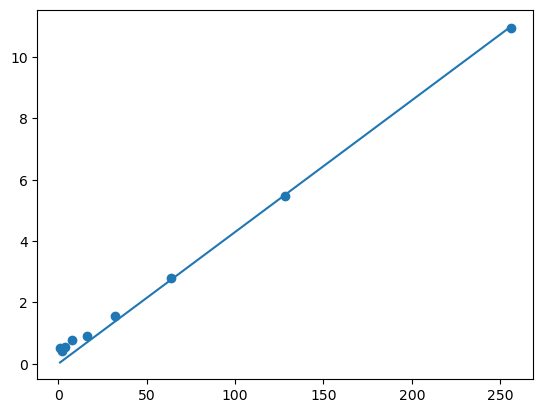

In [51]:
plt.scatter(pipeline_test['sizes'], pipeline_test['times'])
plt.plot(pipeline_test['sizes'], np.array(pipeline_test['sizes']) * slope)

seems like batch size does not really matter for generation speed- seconds/sample stays the same. 

(array([1369912., 1296071., 1169166., 1188548., 1254232., 1254297.,
        1195128., 1172525., 1303027., 1380006.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

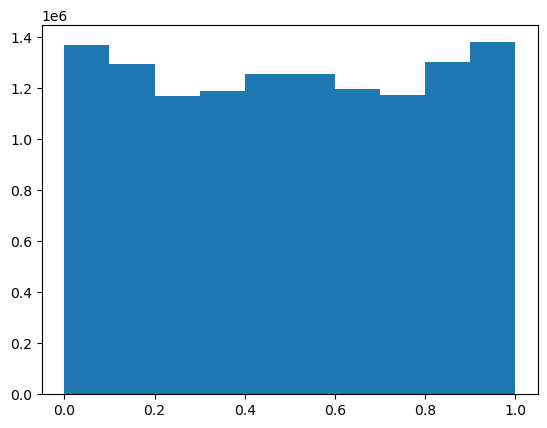

In [58]:
plt.hist(np.array(pipeline_test['batches'][-1]).flatten())

In [41]:
images = np.transpose(images, (0, 3, 1, 2))
images.shape

(5, 128, 16, 24)

In [ ]:
def denoise_input(model_output: ):
    # Input: 

In [ ]:
plt.imshow(images[0, 59])

### Comparing norms to saved

In [78]:
from climsim_data_utils import data_utils, load_vars

In [79]:
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
grid_info = xr.open_dataset(mapper, engine='zarr')

dutils = data_utils(grid_info=grid_info)

In [81]:
def reconstruct_np(X_norm, Y_norm, data_vars='v1'):
    inputs, outputs = load_vars(data_vars)
    input_mean = xr.open_dataset('Climsim_info/input_mean.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values
    input_max = xr.open_dataset('Climsim_info/input_max.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values
    input_min = xr.open_dataset('Climsim_info/input_min.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values
    output_scale = xr.open_dataset('Climsim_info/output_scale.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values

    X = X_norm*(input_max - input_min) + input_mean
    Y = Y_norm / output_scale
    return(X,Y)

In [59]:
x_avg = x_npy.mean(axis=0)
x_avg.shape

(124,)

In [60]:
x_norm = xr.open_dataset("Climsim_info/input_mean.nc")

In [64]:
x_norm_v1 = x_norm[dutils.v1_inputs].to_stacked_array('mlvar', sample_dims='').values

In [75]:
(x_avg -x_norm_v1)

array([-2.56817731e-02,  4.18193672e-02,  9.98839433e-03,  6.54797630e-05,
        2.16402490e-03, -2.84236218e-03, -7.80040626e-03, -7.79458220e-04,
        6.23871345e-03,  5.40563035e-03,  2.17198329e-03,  3.37880128e-04,
       -5.97191006e-04, -9.69804839e-04,  5.85265309e-04,  1.21450536e-03,
       -3.11999986e-03, -3.44376894e-03,  5.46327227e-03,  7.97039341e-03,
        6.71671362e-03,  5.06742930e-03,  2.17408058e-03, -1.35648329e-03,
       -4.15770949e-03, -6.98711656e-03, -9.16070289e-03, -1.06326176e-02,
       -1.12655234e-02, -1.12312231e-02, -1.09699861e-02, -1.07240824e-02,
       -1.05749213e-02, -1.01690826e-02, -9.24284257e-03, -7.57338261e-03,
       -5.09230842e-03, -2.87782532e-03, -1.14609395e-03,  4.11092162e-04,
        1.60435950e-03,  2.65040335e-03,  3.15641661e-03,  3.28444663e-03,
        3.01585356e-03,  2.99826758e-03,  4.39359316e-03,  7.46977212e-03,
        1.22814718e-02,  1.88928090e-02,  2.60559371e-02,  3.35944514e-02,
        4.12411248e-02,  

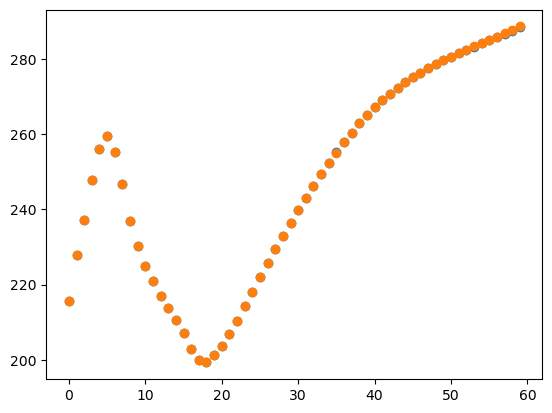

In [69]:
plt.scatter(np.arange(60), x_norm_v1[:60])
plt.scatter(np.arange(60), x_avg[:60])

In [45]:
output_scaling = xr.open_dataset("Climsim_info/output_scale.nc")

oscaling  = output_scaling[dutils.v1_outputs].to_stacked_array('mlvar', sample_dims='').values

In [52]:
y_avg = y_npy.mean(axis=0)
y_scale_test = 1./ y_avg

/tmp/ipykernel_626/3185387537.py:2: RuntimeWarning: divide by zero encountered in divide
  y_scale_test = 1./ y_avg


In [54]:
y_avg

array([ 1.19014050e-05, -1.13608688e-05, -5.22001272e-06, -1.83795208e-06,
       -1.83506310e-06,  7.04202705e-07,  1.36045056e-06,  8.66873477e-07,
        1.65614915e-08, -9.96006355e-08,  3.42032446e-07,  5.19593379e-07,
        6.27532105e-07,  6.53872793e-07,  7.57789509e-07,  1.05315910e-06,
        1.64673863e-06,  1.35920795e-06,  6.38992441e-07, -5.41416933e-07,
       -6.43335666e-09, -2.26299367e-06, -3.69347862e-06, -5.13319715e-06,
       -6.32380659e-06, -6.27994870e-06, -5.32568580e-06, -4.25518677e-06,
       -3.33941632e-06, -2.52159343e-06, -1.73624515e-06, -1.34164169e-06,
       -6.12715034e-07,  1.00480138e-07,  6.40130091e-07,  8.57316853e-07,
        1.44235977e-06,  1.70224506e-06,  1.48805081e-06,  1.39098697e-06,
        1.65367745e-06,  2.02146425e-06,  1.71443179e-06,  1.11403501e-06,
        1.36902466e-06,  1.54391288e-06,  2.10816170e-06,  3.53536307e-06,
        4.23332185e-06,  5.19102267e-06,  4.95795627e-06,  6.65066905e-06,
        7.07406187e-06,  

In [53]:
y_scale_test

array([ 8.40236928e+04, -8.80214374e+04, -1.91570414e+05, -5.44083826e+05,
       -5.44940390e+05,  1.42004567e+06,  7.35050598e+05,  1.15357088e+06,
        6.03810352e+07, -1.00400966e+07,  2.92369923e+06,  1.92458187e+06,
        1.59354397e+06,  1.52934945e+06,  1.31962767e+06,  9.49524147e+05,
        6.07260911e+05,  7.35722592e+05,  1.56496374e+06, -1.84700540e+06,
       -1.55439851e+08, -4.41892530e+05, -2.70747472e+05, -1.94810363e+05,
       -1.58132604e+05, -1.59236969e+05, -1.87769245e+05, -2.35007311e+05,
       -2.99453528e+05, -3.96574637e+05, -5.75955532e+05, -7.45355490e+05,
       -1.63208008e+06,  9.95221566e+06,  1.56218246e+06,  1.16642989e+06,
        6.93308299e+05,  5.87459482e+05,  6.72020063e+05,  7.18913996e+05,
        6.04712847e+05,  4.94690916e+05,  5.83283632e+05,  8.97637854e+05,
        7.30447030e+05,  6.47704940e+05,  4.74346915e+05,  2.82856380e+05,
        2.36221113e+05,  1.92640268e+05,  2.01696010e+05,  1.50360812e+05,
        1.41361500e+05,  

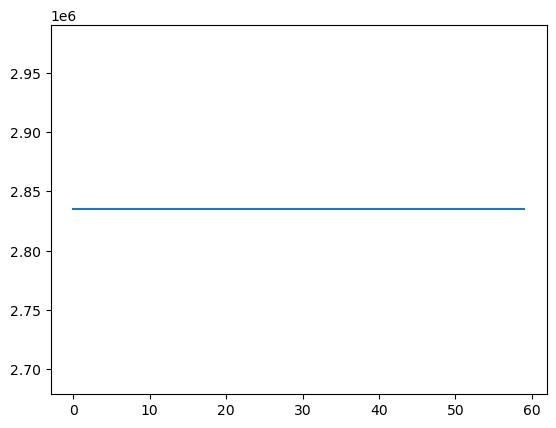

In [56]:
plt.plot(np.arange(60), oscaling[60:120])
#plt.plot(np.arange(60), y_scale_test[60:120])

In [33]:
oscaling.values()

ValuesView(<xarray.Dataset> Size: 1kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables:
    ptend_t         (lev) float64 480B ...
    ptend_q0001     (lev) float64 480B ...
    cam_out_NETSW   float64 8B ...
    cam_out_FLWDS   float64 8B ...
    cam_out_PRECSC  float64 8B ...
    cam_out_PRECC   float64 8B ...
    cam_out_SOLS    float64 8B ...
    cam_out_SOLL    float64 8B ...
    cam_out_SOLSD   float64 8B ...
    cam_out_SOLLD   float64 8B ...)

## Evaluating

Series of evaluation metrics between two datasets $\mathcal S_r$ (training corpus) and $\mathcal S_f$ (generated images) respectively. Idea is to use N samples from each learned distribution and rate model on some kind of distribution distance metric. 

In [20]:
from torch.utils.data import DataLoader
torch.no_grad()


In [21]:
hasattr(mconfig, "num_inference_steps")

False

In [153]:
class SampleImages(torch.utils.data.IterableDataset):
    def __init__(self, pipeline, steps, batch_size=1, eta=1.0):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.pipeline = pipeline.to(self.device)
        self.steps = steps
        self.batch_size = batch_size
        self.eta = 1.0
        
    def __iter__(self):
        # generate a batch of images
        while(True): # can generate infinite batches
            images = pipeline(
                batch_size=self.batch_size, num_inference_steps=self.steps, 
                output_type='numpy', eta=self.eta,
            )
            yield(torch.tensor(images.images, device=device))

def compute_statistics(dataloader, num_samples, encoder):
    encoder.eval()
    features = []
    num_batches = num_samples // dataloader.batch_size + 1
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            print(f"batch {batch_idx}/{num_batches}")
            if batch_idx >= num_batches:
                break
            mu, sigma = encoder(batch)
            features.append(mu.view(mu.size(0), -1))  # Flatten each feature map
        all_features = torch.cat(features, dim=0)
        N, D = all_features.shape # combined into one huge num_samples x feature_size matrix
        assert N == num_batches*dataloader.batch_size, "Matrix dimensions do not match"
        mean = all_features.mean(dim=0)
        covariance = torch.mm((all_features - mean).T, (all_features - mean)) / (N-1) # feature_size by feature_size
    return mean, covariance, all_features

In [90]:
pipeline

DDIMPipeline {
  "_class_name": "DDIMPipeline",
  "_diffusers_version": "0.30.0",
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [110]:
mu, sigma = vae.encoder(images)
mu.shape, sigma.shape

(torch.Size([8, 16, 24, 16]), torch.Size([8, 16, 24, 16]))

In [154]:
model_loader = SampleImages(pipeline, steps=50, batch_size=256)
model_loader.eta = 0

In [156]:
model_mean, model_covariance, all_features = compute_statistics(model_loader, 256, vae.encoder)

  0%|          | 0/50 [00:00<?, ?it/s]

batch 0/2


  0%|          | 0/50 [00:00<?, ?it/s]

batch 1/2


  0%|          | 0/50 [00:00<?, ?it/s]

batch 2/2


In [164]:
model_covariance.shape

torch.Size([6144, 6144])

In [172]:
eps = 5
torch.cholesky(eps*torch.eye(6144, device=device), upper=False)

tensor([[2.2361, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2361, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.2361,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 2.2361, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.2361, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.2361]],
       device='cuda:0')

In [150]:
meana = all_features.mean(dim=0)

In [152]:
(all_features - meana).shape

torch.Size([768, 6144])

In [127]:
data_covariance.T == data_covariance

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
# npcov = np.cov(all_features.numpy(), rowvars=False)
#np.isclose(npcov, covariance.detach().numpy()).all()

In [115]:
test_dl = DataLoader(test_ds, shuffle=True, batch_size = model_loader.batch_size)

In [167]:
data_mean, data_covariance, data_features = compute_statistics(test_dl, 1000, vae.encoder)

batch 0/4
batch 1/4
batch 2/4
batch 3/4
batch 4/4


Frechet Code copied and modified from pytorch-fid library [source code](https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py)

In [144]:
model_covariance > 0

tensor([[ True, False,  True,  ...,  True,  True, False],
        [False,  True, False,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False, False],
        ...,
        [ True, False, False,  ...,  True,  True, False],
        [ True, False, False,  ...,  True,  True, False],
        [False,  True, False,  ..., False, False,  True]], device='cuda:0')

In [131]:
model_covariance.shape

torch.Size([6144, 6144])

In [143]:
mat = data_covariance @ model_covariance
torch.linalg.cholesky(mat + torch.eye(6144, device=device)).to(torch.float32)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 471 is not positive-definite).

##### FID:

- [Frechet Inception Distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)
- Implementation inspired by [pytorch-frechet github](https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/fid.py)



In [123]:
def frechet_distance(dl1, dl2, encoder, num_samples):
    """
    Compute the Frechet Inception Distance (FID) between two datasets.

    Parameters:
    - dl1: A dataloader type iterator with N images.
    - dl2: A dataloader type iterator with M images.
    - encoder: A PyTorch nn.Module that outputs latent representations.
    - num_samples want drawn from distribution to compute FID

    Returns:
    - FID score as a float.
    """
    mean1, cov1, features1 = compute_statistics(dl1, num_samples, encoder)
    mean2, cov2, features2 = compute_statistics(dl2, num_samples, encoder)
    
    # Compute FID score
    mean_diff = torch.norm(mean1 - mean2).item()
    
    # Compute covariance matrix term
    cov_mean = (cov1 + cov2) / 2
    cov_sqrt, _ = torch.linalg.cholesky(cov1 @ cov2).to(torch.float32)
    
    fid_score = mean_diff**2 + torch.trace(cov1 + cov2 - 2 * cov_sqrt).item()
    return fid_score


In [130]:
np.linalg.eigvals(data_covariance.detach().cpu())

array([6.1020929e+02, 7.0041771e+01, 4.5053478e+01, ..., 5.2194338e-08,
       5.2091185e-08, 5.2340226e-08], dtype=float32)

In [124]:
frechet_distance(model_loader, test_dl, vae.encoder, 1000)

  0%|          | 0/50 [00:00<?, ?it/s]

batch 0/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 1/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 2/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 3/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 4/4
batch 0/4
batch 1/4
batch 2/4
batch 3/4
batch 4/4


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 3 is not positive-definite).

## Using Pipeline to Actually Denoise Sample

Let's imagine $x_{in} \in \mathbb{R}^{C \times H \times W}$ is the output of your ML emulator. I want to perturb $x$ to a noisy sample $z_t$; the larger the t, the further away I am taking from the image manifold before denoising back. 


Confusions: if I set the timesteps to some stride for faster inference (90, 80, etc) how does step work? Am I going from 90->80? Or 90 to 89? 

In [ ]:
train_ds = diff.ClimsimImageDataset(Xarr, Yarr, mconfig=mconfig, device=device, channel_first=True)

In [142]:
x_in = train_ds[0].unsqueeze(0)
x_in.shape

torch.Size([1, 128, 16, 24])

In [93]:
scheduler.set_timesteps(50)
print(scheduler.timesteps) # x_t-1 becomes x80 | x90
print(scheduler.config.num_train_timesteps, scheduler.num_inference_steps)
scheduler.set_timesteps(100)

tensor([98, 96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64,
        62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28,
        26, 24, 22, 20, 18, 16, 14, 12, 10,  8,  6,  4,  2,  0])
100 50


In [94]:
def sample_xt(x0, t, scheduler):
    eps = torch.randn(x0.shape, device=device) # BS x C x H x W
    xt = scheduler.add_noise(x0, eps, timesteps=torch.tensor(10, dtype=torch.int32)) # noisy image
    return(xt, eps)

In [107]:
T, stride = 20, 2
scheduler.set_timesteps(scheduler.config.num_train_timesteps // stride)
scheduler.timesteps[-T//stride-1:]

tensor([20, 18, 16, 14, 12, 10,  8,  6,  4,  2,  0])

In [118]:
image, eps = sample_xt(x_in, T, scheduler=scheduler)

In [98]:
at = scheduler.alphas_cumprod[T]
iman = torch.sqrt(at) * x_in + torch.sqrt(1-at)*eps
(iman == image).all()

tensor(True)

In [109]:
eta = 0.2

In [100]:
#plt.imshow(image[0, 59] - x_in[0, 59])

In [139]:
x_in.shape

torch.Size([1, 128, 16, 24])

In [171]:
def correct_image(sample, pipe, T=10, stride=1, eta=0, return_history=True):
    """
    Takes in emulator output and uses diffusion pipeline to bring back to distribution
    Args:
        sample : emulator output, B x C x H x W
        pipe : trained diffusion pipeline
        T : which timestep to bring sample to before denoising. Trade off between diffusion trust and emulator trust
        stride : stride of traversing markov chain. For example, T=20, stride=2 means predict t=20, 18, 16, etc
        eta : eta parameter in DDIM paper
        return_history (bool) : whether to return all timesteps or just x0 hat
    """
    hist = {}
    image, eps = sample_xt(sample, T, scheduler=pipe.scheduler)
    pipe.scheduler.set_timesteps(scheduler.config.num_train_timesteps // stride)
    pipe.scheduler.timesteps[-T//stride-1:]
    with torch.no_grad():
        for t in pipeline.progress_bar(pipe.scheduler.timesteps[-T//stride-1:]):
            model_output = pipeline.unet(image, t).sample
        
            # 2. predict previous mean of image x_t-1 and add variance depending on eta in [0, 1]
            # do x_t -> x_t-1
            image = pipe.scheduler.step(
                model_output, t, image, eta=eta, use_clipped_model_output=False,
            ).prev_sample
            if(return_history):
                hist[t.item()] = image

    #image = (image / 2 + 0.5).clamp(0, 1)
    #image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    
    if(return_history):
        return(image, hist)
    return(image)

In [172]:
denoised_image, history = correct_image(x_in, pipeline, T=20, stride=2)

  0%|          | 0/11 [00:00<?, ?it/s]

In [173]:
history.keys()

dict_keys([20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0])

In [174]:
print(denoised_image.shape)
(denoised_image == history[0]).all()

torch.Size([1, 128, 16, 24])


tensor(True)

In [175]:
denoised_image.device

device(type='cpu')

(array([ 9904.,  3771.,  3695.,  3560.,  3080.,  2686.,  2812.,  2961.,
         3787., 12896.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

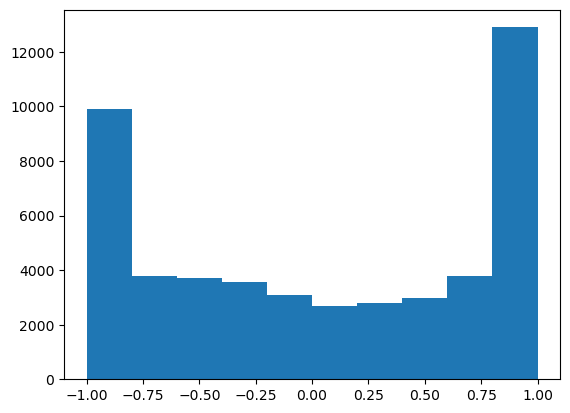

In [176]:
plt.hist(denoised_image.flatten())

(array([2.9500e+02, 3.8060e+03, 1.7294e+04, 2.0226e+04, 6.8030e+03,
        6.2800e+02, 8.1000e+01, 1.4000e+01, 3.0000e+00, 2.0000e+00]),
 array([-3.71876931, -2.53953576, -1.36030233, -0.18106887,  0.99816459,
         2.1773982 ,  3.35663152,  4.53586483,  5.71509838,  6.89433193,
         8.07356548]),
 <BarContainer object of 10 artists>)

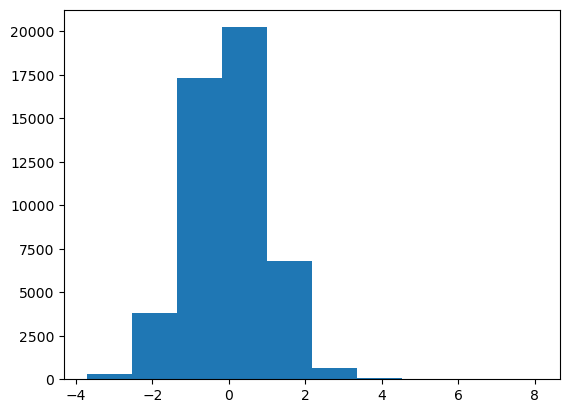

In [154]:
plt.hist(train_ds[0].flatten())

(array([ 9877.,  3744.,  3784.,  3554.,  3020.,  2825.,  2648.,  2939.,
         3862., 12899.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

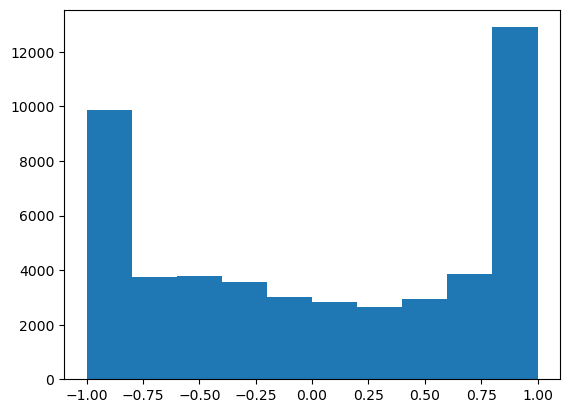

In [122]:
plt.hist(image.detach().cpu().numpy().flatten())

### Trying to use data utils

replicate https://leap-stc.github.io/ClimSim/evaluation/main_figure_generation.html


https://github.com/leap-stc/ClimSim/blob/main/preprocessing/create_npy_data_splits.ipynb

In [19]:
from climsim_data_utils import data_utils, load_vars, setup_data_utils
from climsim_data_utils import *

In [21]:
def setup_data_utils(ds_type='aquaplanet', data_source='gcsfs', data_vars='v1', **kwargs):
    # data source is either a google cloud bucket, local file path, or tries to load directly from Huggingface
    ds_type = expand_ds_name(ds_type)
    if('grid_info' in kwargs):
        grid_info = kwargs['grid_info']
    else:
        grid_url = f"https://huggingface.co/datasets/LEAP/{ds_type}/resolve/main/{ds_type}_grid-info.nc"
        grid_info = read_url_xarray(grid_url)
        
    data = data_utils(data_source, ds_type, grid_info.compute())
    if(data_source == 'hf'):
        data.data_path = f"https://huggingface.co/datasets/LEAP/{ds_type}/resolve/main/train/"
    elif(data_source == 'local' or data_source == "gcsfs"):
        #assert 'base_dir' in kwargs, "Need to provide base path via base_dir arg"
        if("base_dir" in kwargs):
            data.data_path = kwargs[base_dir]
    else:
        print("Invalid data source, must be hf, local, or gcsfs")
    if(data_vars == 'v1'):
        data.set_to_v1_vars()
    elif(data_vars == 'v2'):
        data.set_to_v2_vars()


    input_mean = xr.open_dataset('Climsim_info/input_mean.nc')
    input_max = xr.open_dataset('Climsim_info/input_max.nc')
    input_min = xr.open_dataset('Climsim_info/input_min.nc')
    output_scale = xr.open_dataset('Climsim_info/output_scale.nc')
    data.set_norm_info(input_mean, input_max, input_min, output_scale)
            
    
    return(data)

In [22]:
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
grid_info = xr.open_dataset(mapper, engine='zarr')

dutils = setup_data_utils(grid_info=grid_info, data_vars='v1')

In [23]:
dutils.input_scoring is None

True

Inspired by [Climsim guide](https://leap-stc.github.io/ClimSim/evaluation/main_figure_generation.html)

In [24]:
# set variables to V1 subset
dutils.set_to_v1_vars()

dutils.input_scoring = x_test
dutils.target_scoring = y_test
# set pressure weights
dutils.set_pressure_grid(data_split = 'scoring')

# load model predictions
dutils.model_names = ['fake_model', 'fake_model_2']
predictions = {
    'fake_model' : y_pred1, 
    'fake_model_2' : y_pred2
}

dutils.preds_scoring = predictions


1. Undo output scaling
2. Weight vertical levels by dp/g
3. Weight horizontal area of each grid cell by a[x]/mean(a[x])
4. Convert units to a common energy unit

In [25]:
dutils.reweight_target(data_split = 'scoring')
dutils.reweight_preds(data_split = 'scoring')

dutils.metrics_names = ['MAE', 'RMSE', 'R2']
dutils.create_metrics_df(data_split = 'scoring')

/home/jovyan/Samarth/2024/climsim_data_utils.py:1267: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/home/jovyan/Samarth/2024/climsim_data_utils.py:1267: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time


In [26]:
dutils.model_names

['fake_model', 'fake_model_2']

In [27]:
dutils.metrics_var_scoring['fake_model']

,MAE,RMSE,R2
variable,,,
ptend_t,0.133498,0.165918,0.87188
ptend_q0001,0.117729,0.146369,-inf
cam_out_NETSW,0.334654,0.41666,-inf
cam_out_FLWDS,0.160149,0.199164,0.999664
cam_out_PRECSC,0.161144,0.200279,-inf
cam_out_PRECC,1.51049,1.877517,-inf
cam_out_SOLS,0.158699,0.197494,-inf
cam_out_SOLL,0.171769,0.214642,-inf
cam_out_SOLSD,0.130798,0.162638,-inf


In [31]:
dutils.metrics_var_scoring['fake_model_2']

,MAE,RMSE,R2
variable,,,
ptend_t,53.524392,66.504104,-20675.23643
ptend_q0001,47.195209,58.636937,-inf
cam_out_NETSW,133.711817,165.237406,-inf
cam_out_FLWDS,62.48986,77.847823,-48.521115
cam_out_PRECSC,64.595863,80.611717,-inf
cam_out_PRECC,615.071302,760.312131,-inf
cam_out_SOLS,63.500213,79.138954,-inf
cam_out_SOLL,68.836698,85.51523,-inf
cam_out_SOLSD,52.464927,65.637407,-inf


In [28]:
dutils.metrics_idx_scoring['fake_model']

,MAE,RMSE,R2
output_idx,,,
0,0.000367,0.000456,0.96964
1,0.000656,0.000818,0.995107
2,0.001162,0.001447,0.986604
3,0.002043,0.002541,0.975119
4,0.003476,0.004299,0.967756
...,...,...,...
123,1.51049,1.877517,-inf
124,0.158699,0.197494,-inf
125,0.171769,0.214642,-inf
